# Прогнозирование стоимости автомобиля по характеристикам
Цель:  
Разработать Multi-input модель для предсказания стоимости автомобиля по различным данным - табличным, текстовым и графическим.

Задачи:  


## Этапы проекта:
* Построение "наивной"/baseline модели, предсказывающей цену по модели и году выпуска (с ней будем сравнивать другие модели)
* EDA и Feature-Engeneering
* В рамках исследования будет создана модель на основе градиентного бустинга с использованием CatBoost
* Исследование табличной нейронной сети
* Комбинирование табличной нейронной сети и NLP в одну multi-input сеть с дальнейшей проверкой метрики
* Исследование нейронной сети для обработки изображений и добавление ее в multi-input сеть
* Ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

# 0. Установка и загрузка библиотек

In [32]:
!pip install --upgrade pip

In [33]:
!pip install -q tensorflow==2.3

In [34]:
# аугментации изображений
!pip install albumentations -q

In [35]:
!pip install pymorphy2
!pip install pymorphy2-dicts

In [36]:
!pip install catboost

In [68]:
import os
import re
import cv2 
import sys
import csv
import PIL
import random
import pickle
import zipfile
import pymorphy2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from nltk.corpus import stopwords
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# keras
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.callbacks import (
    Callback, 
    ModelCheckpoint, 
    EarlyStopping,
    ReduceLROnPlateau,
    LearningRateScheduler, 
)
from tensorflow.keras.optimizers.schedules import *
import albumentations as a

import PIL
from PIL import ImageOps, ImageFilter

# plt
import matplotlib.pyplot as plt
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

#pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

Посмотрим версии используемых библиотек

In [38]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.13 (default, Apr 24 2022, 01:04:09) 
Numpy        : 1.21.6
Tensorflow   : 2.3.0


Зафиксируем версию пакетов:

In [39]:
!pip freeze > requirements.txt

Теперь установим random seed:

In [40]:
RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)

Вспомогательный флаг для удобства использования на раных платформах

In [41]:
# True - для Google Colab
# False - для Kaggle
is_colab = True

Пропишем функцию для вычисления метрики MAPE

In [42]:
def mape(y_test, y_pred):
    return np.mean(np.abs((y_pred-y_test)/y_test))

# 1. DATA

Пути к данным и рабочим папкам

In [43]:
if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')

if is_colab:
    # Colab
    DATA_PATH = os.path.abspath('/content/drive/MyDrive/Colab Notebooks'
                                '/project_8/input'
                                '/sf-dst-car-price-prediction-part2/')
    SAVE_PATH = os.path.abspath('/content/drive/MyDrive/Colab Notebooks'
                                '/project_8/saves_models')
    WORK_PATH = os.path.join(os.getcwd(), 'working')
else:
    # Kaggle
    DATA_PATH = os.path.abspath('../input/sf-dst-car-price-prediction-part2/')
    SAVE_PATH = os.path.abspath('../input/saves-models')
    WORK_PATH = os.path.abspath('./')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузим наш обучающий и тестовый фреймы:

In [44]:
train = pd.read_csv(os.path.join(DATA_PATH,'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH,'test.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH,'sample_submission.csv'))

Проверим, что у нас находится в обучающем и тестовом фреймах

In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [46]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [48]:
train.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                4326
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

Мы видим, что присутствуют пропуски, которые в дальнейшем придется обработать каким-либо способом.  

Проверим что находится в тестовом фрейме:

In [49]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

In [50]:
test.nunique()

bodyType                  14
brand                      3
color                     15
description             1540
engineDisplacement        43
enginePower              120
fuelType                   4
mileage                  935
modelDate                 37
model_info               101
name                     536
numberOfDoors              4
productionDate            35
sell_id                 1671
vehicleConfiguration     205
vehicleTransmission        4
Владельцы                  3
Владение                 131
ПТС                        2
Привод                     3
Руль                       1
dtype: int64

In [51]:
test.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  0
Владение                1092
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

Здесь пропуски имеются только в столбце "владение". В дальнейшем нужно будет обработать.

In [71]:
train.sample(7)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
3123,внедорожник 5 дв.,AUDI,белый,РОЛЬФ - Официальный дилер и Лучший дилер Росси...,2.0 LTR,177 N12,дизель,93842,2012,Q5,2.0d AMT (177 л.с.) 4WD,5,1490000.0,2015,1099387282,ALLROAD_5_DOORS ROBOT 2.0,роботизированная,2 владельца,NaN,Оригинал,полный,Левый
2721,внедорожник 5 дв.,MERCEDES,чёрный,Новый авто!! В наличии! Максимальной комплекта...,4.0 LTR,585 N12,бензин,17,2018,G_KLASSE_AMG,63 AMG 4.0 AT (585 л.с.) 4WD,5,18700000.0,2020,1099459954,ALLROAD_5_DOORS AUTOMATIC 4.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый
6608,внедорожник 5 дв.,MERCEDES,белый,"Машина G63 amg, указал этот двигатель потому ч...",5.5 LTR,388 N12,бензин,54000,2012,G_KLASSE,500 5.5 AT (388 л.с.) 4WD,5,5300000.0,2014,1100173698,ALLROAD_5_DOORS AUTOMATIC 5.5,автоматическая,3 или более,NaN,Дубликат,полный,Левый
4795,седан,BMW,чёрный,Сразу обозначу про хозяев: реально-2 владельца...,6.0 LTR,445 N12,бензин,178000,2005,7ER,760Li 6.0 AT (445 л.с.),4,550000.0,2006,1086888385,SEDAN AUTOMATIC 6.0,автоматическая,3 или более,NaN,Дубликат,задний,Левый
2018,хэтчбек 5 дв.,BMW,чёрный,Машина в хорошем состоянии. Торг у капота .,1.6 LTR,115 N12,бензин,176000,2007,1ER,116i 1.6 MT (115 л.с.),5,385000.0,2007,1090032154,HATCHBACK_5_DOORS MECHANICAL 1.6,механическая,3 или более,NaN,Дубликат,задний,Левый
4003,внедорожник 5 дв.,BMW,серый,Авто в хорошем состоянии без каких либо технич...,3.0 LTR,235 N12,дизель,265000,2006,X5,3.0d 3.0d AT (235 л.с.) 4WD,5,900000.0,2008,1096129272,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
2122,седан,BMW,коричневый,Состояние автомобиля отличное. Не требует ника...,2.0 LTR,184 N12,бензин,127000,2009,5ER,520i 2.0 AT (184 л.с.),4,1050000.0,2013,1099976772,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,NaN,Оригинал,задний,Левый


In [72]:
test.sample(7)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
1308,седан,MERCEDES,синий,"Отличное состояние, пробег реальный. Сделано б...",1.8 LTR,143 N12,бензин,212000,2004,C_KLASSE,180 1.8 MT (143 л.с.),4,2006,1100143146,SEDAN MECHANICAL 1.8,механическая,3 или более,NaN,Оригинал,задний,Левый
843,внедорожник 5 дв.,BMW,чёрный,Акустика Harman Kardon.\nКожаные сиденья (Dako...,2.0 LTR,245 N12,бензин,54780,2014,X4,28i 2.0 AT (245 л.с.) 4WD,5,2017,1099486318,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,1 владелец,2 года и 4 месяца,Оригинал,полный,Левый
128,хэтчбек 5 дв.,MERCEDES,чёрный,\nСама выполняет параллельную парковку.\nПеред...,1.6 LTR,122 N12,бензин,170000,2011,B_KLASSE,180 1.6 AMT (122 л.с.),5,2012,1098776926,HATCHBACK_5_DOORS ROBOT 1.6,роботизированная,2 владельца,4 года,Оригинал,передний,Левый
1639,купе,MERCEDES,белый,Автомобиль в отличном состоянии.\nПриобретен в...,3.0 LTR,435 N12,бензин,8900,2016,E_KLASSE_AMG,53 AMG 3.0 AT (435 л.с.) 4WD,2,2018,1099599146,COUPE AUTOMATIC 3.0,автоматическая,2 владельца,10 месяцев,Оригинал,полный,Левый
522,внедорожник 5 дв.,BMW,коричневый,Безопасность: 2. Комфорт: 3. Элементы экстерье...,2.0 LTR,184 N12,дизель,107417,2012,X1,20d 2.0d AT (184 л.с.) 4WD,5,2013,1099552276,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,полный,Левый
259,внедорожник 5 дв.,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,5.4 LTR,507 N12,бензин,52455,2008,G_KLASSE_AMG,55 AMG 5.4 AT (507 л.с.) 4WD,5,2009,1100076402,ALLROAD_5_DOORS AUTOMATIC 5.4,автоматическая,1 владелец,NaN,Оригинал,полный,Левый
1666,седан,BMW,коричневый,Продаётся любимица семьи. Автомобилем неактивн...,2.0 LTR,184 N12,бензин,76000,2011,3ER,320i 2.0 AT (184 л.с.),4,2012,1099414488,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,7 лет,Оригинал,задний,Левый


В обоих датафреймах столбцы совпадают.

Определим типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

Теперь попробуем создать наивную модель и посмотреть результат нашей метрики

# 2. Model 0: "Наивная" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



Первым делом проведем разделенение на обучающую и валидационную выборки:

In [73]:
data_train, data_test = train_test_split(
    train, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

Создадим наивную модель и проведем оценку отчности:

In [112]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 
                                          'productionDate']]).iterrows():
    predicts.append(data_train.loc[(data_train['model_info'] == row[0]) & 
                                   (data_train['productionDate'] == row[1])]
                    ['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000
# print(data_test['price'].values)
# print(predicts.values[:, 0])

# оцениваем точность
print(f"Ошибка по метрике MAPE: "
      f"{(mape(data_test['price'].values, predicts.values[:, 0]))*100:0.2f}%")


Ошибка по метрике MAPE: 20.26%


Мы получили достаточно плохой результат, но теперь появилось понимание - откуда отталкиваться. 

Первым делом проведем EDA и попробуем использовать CatBoost.

# 3. EDA и Feature-Engeneering

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм. По большей части EDA и Feature-Engeneering был произведен в одном из предыдущих проектов CarPricePrediction, поэтому многие вещи будут заимствованы оттуда.

Посмотрим, как выглядят распределения числовых признаков:

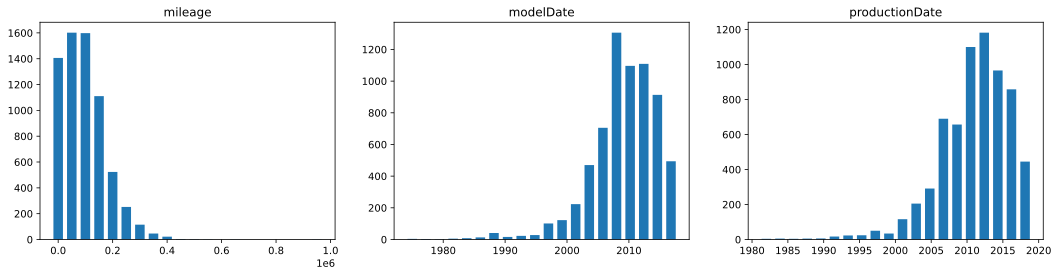

In [113]:
# посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize=(columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins=20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width=(bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()


visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

## 3.1. Предобработка табличных данных

Объединим тестовый и обучающий фреймы в один:

In [120]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1  # трейн
test['sample'] = 0  # тест
test['price'] = 0  # в тесте нет значения price,  заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True)  # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


Теперь приступим к предобработке

### 3.1.1. bodyType

Данный столбец отражает тип кузова автомобиля. Посмотрим на количество вариантов:

In [ ]:
data.bodyType.unique()

Проведем обработку данных:

In [ ]:
# Выбираем первое слово для описания типа кузова
data['bodyType'] = data['bodyType'].astype(
    str).apply(lambda x: None if x.strip() == '' else x)
# Понижаем регистр первого слова
data['bodyType'] = data.bodyType.apply(lambda x: x.split(' ')[0].lower())

Посмотрим количество уникальных значений:

In [ ]:
train.bodyType.unique()

Проверим распределение значений по типу кузова:

In [ ]:
data.bodyType.value_counts().plot.barh()

В дальнейшем признак отнесем к категориальным.

### 3.1.2. brand

Данный столбец отражает название фирмы-производителя автомобиля. Проверим уникальные значения:

In [ ]:
data.brand.unique()

Как мы видим, уникальных значений мало, можно оставить без изменений. Посмотрим распределение значений:

In [ ]:
data.brand.value_counts().plot.barh()

Отнесем признак к категориальным.

### 3.1.3. color

Данный признак отражает цвет продаваемого автомобиля. Посмотрим количество уникальных значений:

In [ ]:
data.color.nunique()

Посмотрим распределение значений по цветам:

In [ ]:
data.color.value_counts().plot.barh()

Отнесем признак к категориальным

### 3.1.4. description

Данный столбец содержит комментарий о продаваемом автомобиле. В дальнейшем будет использоваться для NLP. Сейчас выделим на основе этого столбца признак, отражающий длину комментария:

In [ ]:
data['comment_length'] = data.description.apply(lambda x: len(str(x)))

In [ ]:
data.comment_length.hist()

Отнесем к числовым признакам

### 3.1.5. engineDisplacement

Этот признак описывает объем двигателя авто. Посмотрим количество уникальных значений :

In [ ]:
data.engineDisplacement.unique()

Мы видим, что признак отражает литраж двигателя с припиской LTR. Попробуем ее убрать:

In [ ]:
data.engineDisplacement = data.engineDisplacement.apply(lambda x: x[:3])

In [ ]:
data.engineDisplacement.value_counts()

Мы видим, что 6 значений имеют und ( остаток от undefined LTR). Заполним значением моды:

In [ ]:
data.engineDisplacement = data.engineDisplacement.replace(
    'und', data.engineDisplacement.mode()[0])

Проверим результат:

In [ ]:
data.engineDisplacement.unique()

Преобразуем в числовой формат и посмотрим распределение:

In [ ]:
data.engineDisplacement = data.engineDisplacement.apply(lambda x: float(x))

In [ ]:
data.engineDisplacement.hist()

Как мы видим, распределение близко к нормальному, но возможно после логарифмирования показатели станут лучше. Отнесем к числовым признакам

### 3.1.6. enginePower

Признак отражает мощность двигателя автомобиля. Посмотрим на уникальные значения:

In [ ]:
data.enginePower.unique()

Избавимся от дополнительной информации в данных:

In [ ]:
# берем 1 символ, если длина строки 5, первые два если 6,в противном случае первые три символа
data['enginePower'] = data['enginePower'].apply(
    lambda x: x[:1] if len(x) == 5 else (x[:2] if len(x) == 6 else x[:3]))

Проверим результат:

In [ ]:
data.enginePower.unique()

Замечательно, теперь переведем в числовой формат и посмотрим распределение значений:

In [ ]:
data['enginePower'] = data['enginePower'].apply(lambda x: int(x))
data.enginePower.hist()

Распределение близко к нормальному, но возможно необходимо будет логарифмировать для улучшения показателей. Отнесем к числовым признакам

### 3.1.7. fuelType

Данный признак содержит данные о типе топлива, используемого в автомобиле. Посмотрим на уникальные значения:


In [ ]:
data.fuelType.value_counts()

Посмотрим распределение признака:

In [ ]:
data.fuelType.hist()

Как видно из графика, подавляющее большинство автомобилей используют бензиновое топливо. Отнесем признак к категориальным.

### 3.1.8. mileage

Признак содержит данные о пробеге продаваемого авто. Проверим данные:

In [ ]:
data.mileage.unique()

Данные чистые. Посмотрим на распределение признака:

In [ ]:
data.mileage.hist(figsize=(8, 5), bins=100)

Проверим на выбросы:

In [ ]:
IQR = data['mileage'].quantile(0.75) - data['mileage'].quantile(0.25)
perc25 = data['mileage'].quantile(0.25)  # 25-й перцентиль
perc75 = data['mileage'].quantile(0.75)  # 75-й перцентиль

print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR,
                                           l=perc75 + 1.5*IQR))

Посмотрим, сколько значений превышает границу:

In [ ]:
data.mileage[data.mileage > 328841].count()

Как мы видим, значений действительно мало. Возможно они действительно являются выбросами, но существуют (основываясь на собственном опыте) автомобили, у которых ОЧЕНЬ большой пробег. Так что предполагаемые выбросы без изменений.

Отнесем признак к числовым и в дальнейшем используем нормализацию.

### 3.1.9. modelDate

Данный признак содержит информацию о годе производства модели авто. Просмотрим уникальные значения:

In [ ]:
data.modelDate.unique()

Теперь построим график распределения для наглядности:

In [ ]:
data.modelDate.hist()

Как мы видим, автомобили представленные в дата-сете, производились в промежутке с 1970 по 2019 год. Создадим новый признак, отражающий возраст модели:

In [ ]:
data['model_time'] = datetime.now().year - data.modelDate

Отнесем признак к числовым.

### 3.1.10 model_info

Данный столбец отражает информацию о модели продаваемого автомобиля. Посмотрим количество уникальных значений:

In [ ]:
data.model_info.value_counts()

Мы имеем одну строчку без указания модели. Посмотрим, что это за строка:

In [ ]:
data.loc[data['model_info'] == 'None']

Видим, что это Mercedes-седан. Посмотрим, возможно в комментарии указана модель:

In [ ]:
data.iloc[2803]['description']

К сожалению, ничего не вышло. Но заполнять значением моды тоже не стоит, чтобы не "придумать" новую модель автомобиля. Оставим без изменений. Отнесем признак к категориальным.

### 3.1.11. name

Столбец дублирует информацию из других столбцов. Единственное, что можно из него выделить - это наличие xDrive в автомобиле. Создадим новый признак:

In [ ]:
data['xDrive'] = data['name'].apply(lambda x: 1 if 'xDrive' in x else 0)

Посмотрим как распределен признак:

In [ ]:
sns.countplot(x='xDrive', data=data)

Как мы видим, большая часть представленных автомобилей не имеет xDrive. Отнесем к категориальным признакам.

### 3.1.12. numberOfDoors

Признак содержит информацию о количестве дверей авто. Посмотрим на уникальные значения:

In [ ]:
data.numberOfDoors.unique()

Как видно, никаких значений, вызывающих сомнения, нет. Проверим распределение признака:

In [ ]:
sns.countplot(x='numberOfDoors', data=data)

Видим, что большая часть авто имеют 4 или 5 дверей. Отнесем к категориальным признакам.

### 3.1.13. productionDate

Признак содержит информацию о годе производства авто. Проверим корреляцию между productionDate и modelDate:

In [ ]:
data[['modelDate', 'productionDate']].corr()

Корреляция очень высокая, значит один признак почти дублирует другой, а это может негативно сказаться на обучении. Во избежание этого, оставим только один из признаков, то есть modelDate, который мы добавили выше.

### 3.1.14. sell_id

Этот признак нам в дальнейшем пригодится для того, чтобы находить изображения по идентификатору объявления. Для табличного обучения информативности не имеет.

### 3.1.15. vehicleConfiguration

Столбец содержит информацию из других столбцов. Информативности не несет

### 3.1.16. vehicleTransmission

Признак содержит информацию о типе коробки передач, используемой в транспортном средстве. Проверим уникальные значения:

In [ ]:
data.vehicleTransmission.unique()

Посмотрим распределение признака:

In [ ]:
sns.countplot(x='vehicleTransmission', data=data)

Подавляющее большинство автомобилей имеют автоматическую коробку передач. Отнесем к категориальным признакам.

### 3.1.17. Владельцы

Признак содержит информацию о количестве владельцев авто. Посмотрим пропуски:

In [ ]:
data.Владельцы.isna().sum()

Всего один пропуск. Посмотрим, что это за строка:

In [ ]:
data[data['Владельцы'].isnull()]

Посмотрим описание, возможно там указано, сколько было владельцев:

In [ ]:
data.iloc[6665]['description']

К сожалению, комментарий оказался неинформативен. Заполним значение модой:

In [ ]:
data.Владельцы = data.Владельцы.apply(
    lambda x: data.Владельцы.mode()[0] if pd.isna(x) else x)

Посмотрим результат:

In [ ]:
data.Владельцы.isna().sum()

Как мы видим, пропущенное значение заполнилось значением моды для этого столбца. Теперь оставим только числовые значения и приведем к числовому виду столбец:

In [ ]:
data['Владельцы'] = data['Владельцы'].apply(
    lambda x: int(x[0])).astype('int32')

Посмотрим распределение:

In [ ]:
data.Владельцы.hist()

Видно что автомобили с 3 владельцами немного преобладают над всеми остальными, но не сильно. Отнесем признак к категориальным.

### 3.1.18. Владение

Данный столбец отражает,сколько времени продавец владеет автомобилем. Посмотрим, сколько пропусков в данном столбце:

In [ ]:
data.Владение.isna().sum()

Посмотрим соотношение пропусков ко всему дата-сету:

In [ ]:
data.Владение.isna().sum()/len(data.Владение)*100

Как видно, пропусков почти 65% дата-сета. Заполнение их каким-либо одним значением сыграет только плохую роль. Лучше данный столбец вообще не включать в обучение.

### 3.1.19. ПТС

Данный признак содержит информацию о ПТС автомобиля. Проверим уникальные значения:

In [ ]:
data.ПТС.unique()

Выведем график распределения признака:

In [ ]:
data.ПТС.hist()

Как видно из распределения - большая часть продавцов имеет оригинал ПТС. Пропусков не наблюдается. Отнесем признак к категориальным.

### 3.1.20. Привод

Признак содержит информацию о том, какой привод у транспортного средства. Посмотрим график распределения признака:

In [ ]:
sns.countplot(x='Привод', data=data)

Видно, что большинство автомобилей имеют полный привод. Пропусков нет, отнесем признак к категориальным.

### 3.1.21. Руль

Признак отражает положение руля в автомобиле. Посмотрим распределение признака:

In [ ]:
sns.countplot(x='Руль', data=data)

Почти все автомобили имеют левый руль, пропусков нет. Отнесем признак к категориальным.

### 3.1.22. Целевой признак - price

Искомый признак, отражающий стоимость автомобиля. Присутствует только в тренировочной выборке. Посмотрим, в каком виде представлена цена:

In [ ]:
data.iloc[6665]['price']

Мусор отсутствует, теперь посмотрим график распределения целевого признака:

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title(f"Распределение столбца {'price'}")
sns.distplot((data[data['sample'] == 1]['price']), bins=50)

plt.subplot(1, 2, 2)
sns.boxplot(data['price'])
plt.xlabel('Price')
plt.title(f"Боксплот столбца {'price'}", fontsize=12)
plt.show()
data.price.describe()

Видно, что данные сильно смещены влево. Посмотрим, как будет себя весть признак после логарифмирования:

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title(f"Распределение после log.{'price'} ")
sns.distplot(np.log(data[data['sample'] == 1]['price']), bins=50)

plt.subplot(1, 2, 2)
sns.boxplot(np.log(data[data['sample'] == 1]['price']))
plt.xlabel('Price')
plt.title('Боксплот после log.price', fontsize=12)
plt.show()

Распределение стало более центрированным, что хорошо. Выбросы трогать не будем, так как стоимость автомобиля указывает владелец, то есть она может быть довольно (а иногда - необоснованно) высокой.

Теперь посмотрим зависимости некоторых столбцов от целевого:

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter((data.price), data.model_time)

Из распределения видно, что чем более "свежий" автомобиль, тем выше на него цена. Но опять же, некоторые более старые автомобили могут стоить дорого из-за раритетности. Посмотрим также зависимость от привода:

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter((data.price), data.Привод)

Опять же, из распределения хорошо видно, что наиболее высокая цена у полного привода, что логично.

Теперь сформируем перечень категориальных и числовых признаков:

In [ ]:
# используем все текстовые признаки как категориальные без предобработки
cat_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info',
                'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'xDrive']

# числовые признаки
num_features = ['mileage', 'modelDate', 'model_time',
                'engineDisplacement', 'enginePower', 'comment_length']

Необходимо посмотреть корреляционную зависимость наших признаков:

In [ ]:
plt.figure(figsize=(12, 7))
sns.heatmap(data[data['sample'] == 1]
            [num_features + ['price']].corr(), annot=True)

Как видно из корреляционной матрицы, есть сильная обратная зависимость между признаками model_time и modelDate. Нейронная сеть simple dense NN очень сильно теряет в MAPE, если убрать хотя бы один из признаков. В рамках эксперимента я поменеял modelDate на productionDate. Корреляция упала с -1 до -0.964, что уже дает хоть какой-то результат. При этом catBoost и DNN стали вести себя гораздо лучше (прогресс со 107 места leaderboard'a на 41). В итоге было решено добавить вместо modelDate в числовые фичи productionDate. Ниже представлена их корреляция и изменение столбца num_features.

In [ ]:
data[['model_time', 'productionDate']].corr()

In [ ]:
# числовые признаки
num_features = ['mileage', 'model_time', 'productionDate',
                'engineDisplacement', 'enginePower', 'comment_length']

Теперь напишем функцию для финального этапа обработки данных:

In [ ]:
def preproc_data(df_input):

    df_output = df_input.copy()

    # Удалим неиспользуемые столбцы
    df_output.drop(['description', 'sell_id', 'vehicleConfiguration',
                    'Владение', 'name', 'modelDate'], axis=1, inplace=True)

    ############################### Нормализация ####################################################################

    scaler = RobustScaler()  # показал наилучший результат из всех scaler'ов
    for column in num_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    #################### Работа с категориальными признаками ############################################################
    # Label Encoding
    for column in cat_features:
        df_output[column], _ = pd.factorize(df_output[column])

    # One-Hot Encoding:
    df_output = pd.get_dummies(
        df_output, columns=cat_features, dummy_na=False)

    return df_output

Применим полученную функцию для предобработки наших данных:

In [ ]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

Теперь, когда мы провели предобработку данных, можно приступать к формированию обучающей и валидационной выборок и исследованию различных моделей 

## 3.2. Split data

Разделим данные обратно на тестовую и обучающую выборки:

In [ ]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

Посмотрим правильно ли все разделилось:

In [ ]:
test_data.info()

Если посмотреть в самое начало, то мы увидим, что правильно: 1671 строка.

Теперь создадим первую не "наивную" модель на основе CatBoost.

# 4. Model 2: CatBoostRegressor

Разделим наш train на обучающую и валидационную выборки:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

Теперь обучим наш CatBoosRegressor:

In [ ]:
model = CatBoostRegressor(iterations=6000,  # Количество итераций
                          # depth=10,
                          #learning_rate = 0.01,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,  # Прерывает выполнение, если нет улучшения 500 итераций
                          # task_type='GPU',
                          )
# обучим модель
model.fit(X_train, np.log(y_train),
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=100,
          use_best_model=True,
          # plot=True
          )

Посмотрим, какая у нас получилась метрика:

In [ ]:
test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

Пробовал различные варианты обучения:
* без логарифмирования target'a и использовании modelDate вместо productionDate MAPE ~ 15%
* с измененным learning rate MAPE ухудшается на ~1% (исследовались lr=0.01, lr=0.005,lr=0.001)
* Различные соотношения тестовой и тренировочной выборки

### Submission

Создадим сабмит:

In [ ]:
sub_predict_catboost = np.exp(model.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('cat_sub.csv', index=False)

По итогам сабмита получили MAPE порядка 11.86%. Предыдущий сабмит был сделан с другим используемым в num_features столбцом и его MAPE была почти на процент хуже.

Уже на данном этапе мы получили результат, который лучше значения baseline. Возможно, если провести еще более детальную предобработку данных и выделить больше фич, которые могут помочь, то метрика улучшится еще сильнее. Также, вероятно, она улучшится, если найти способ побороть высокую корреляцию между некоторыми столбцами.

Тем не менее, результат вышел довольно неплохой, хотя при этом мы используем далеко не все столбцы, которые могли бы. В дальнейшем попробуем исправить это упущение, а сейчас перейдем к варианту обработки данных при помощи табличной нейронной сети.

# 5. Model 3: Табличная нейронная сеть

Проверим наш обучающий дата-сет:

In [ ]:
X_train.head(5)

### 5.1. Simple Dense NN

Создадим простую Dense сеть.

На данном этапе было перепробовано несколько подходов с различным количеством и размером dense-слоев, функциями активации, количеством dropout-слоев. Наиболее удачным оказался вариант с активацией relu всех dense-слоев и kernel-регуляризацией. были исследованы другие способы регуляризации, но результат получался хуже.

Финальный вариант исследуемой сети представлен ниже:

In [ ]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, kernel_regularizer=regularizers.l2(
    l2=1e-6), activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(128, kernel_regularizer=regularizers.l2(
    l2=1e-5), activation="relu"))
model.add(L.Dropout(0.25))
model.add(L.Dense(1, activation="linear"))

Посмотрим структуру модели:

In [ ]:
model.summary()

Укажем оптимизатор с скоростью обучения 0.005 и скомпилируем модель:

In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

Пропишем наши коллбеки:
* earlystop - Для прерывания обучения в случае, когда нет положительного результата на протяжении **patience** эпох.
* checkpoint - Сохраняет лучшие веса модели

In [ ]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### 5.2. Fit

Обучаем нашу простую модель в течение 500 эпох. По факту, до конца это обучение дойдет вряд ли, потому что рано или поздно сработает EarlyStopping, который прервет процесс обучения, если не было положительной динамики 50 эпох. Валидацию проводим на валидационной части нашего дата-сета.

In [ ]:
history = model.fit(X_train, (y_train),
                    batch_size=512,  # размер батча
                    epochs=500,  # количество эпох для обучения
                    validation_data=(X_test, (y_test)),  # данные для валидации
                    callbacks=callbacks_list,  # список  наших коллбэков
                    verbose=0,  # параметр, отвечающий за выведение прогресс-бара
                    )

Посмотрим график Loss-функции:

In [ ]:
plt.title('Loss Function')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

Из графика видно, что вначале происходит резкий спад функции, но потом понижение происходит очень медленно, и к ~ 250 эпохе срабатывает прерывание выполнения из-за отсутствия положительного результата.

Сохраним модель и загрузим лучшие веса:

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

Проверим исследуемую метрику:

In [ ]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

Метрика получилась гораздо лучше, чем при использовании CatBoostRegressor'a, значит мы движемся в правильном направлении.

Сделаем сабмит:

In [ ]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:, 0]
sample_submission.to_csv('nn1_submission.csv', index=False)

На данном этапе я получил результат mape:11.36% на тестовой выборке, что улучшило предыдущий результат почти на пол процента.

До этого был сабмит с modelDate вместо productionDate - результат mape был примерно 12.15%.

Результат получился еще лучше, чем предыдущий. Значит, в данном случае наша нейронная сеть лучше решает поставленную задачу. Это дает несколько поводов для размышления, что делать дальше, чтобы еще сильнее улучшить исследуемую метрику. На данном этапе есть несколько вариантов: 
* Исследовать различные варианты архитектуры сети и ее параметры дальше
* Исследовать известные готовые варианты табличных нейронных сетей
* Попробовать дополнить архитектуру сети, сделав из нее multi-input сеть

Мы выберем последний вариант, так как помним, есть данные, которые мы до сих пор не использовали в обучении. Перейдем к созданию первой multi-input сети.

# 6. Model 4: NLP + MLP Multi Input NN

Для данной модели мы будем использовать две сети:
* NLP для обработки столбца description
* MLP, созданная ранее, для табличных данных

Для начала посмотрим, как выглядят данные в столбце:

In [ ]:
data.description

Мы видим, что столбец представляет собой комментарий к продаваемому автомобилю. В нем присутствует мусор, от которого нужно будет избавиться. План действий будет примерно следующим:
* Очистим строки от ненужных символов
* Проведем лемматизацию строк
* Уберем стоп-слова из строк
* Проведем токенизацию текста
* Проведем векторизацию текста

## 6.1. Лемматизация

    Данный этап стал для меня первым камнем преткновения. Сначала была идея использовать BERT, но моих знаний оказалось недостаточно, чтобы понять как его полноценно использовать. Потом я пытался использовать spacy для обработки текста, но она отказалась подгружать русскую библиотеку слов, а предлогаемые неофициальные решения со словарями мне показались не слишком подходящими. Поэтому я вернулся к тому, с чего начинал : pymorphy2 для лемматизации слов и nltk для удаления стоп-слов.

Суть лемматизации заключается в том, чтобы вернуть каждое слово к его изначальной словоформе. Это нужно, чтобы не считать разные формы слова "уникальными" при обработке текста.

Загрузим морфологический анализатор и скопируем данные из исходного дата-сета:

In [ ]:
morphy = pymorphy2.MorphAnalyzer()
df_NLP = data.copy()

Создадим паттерн с "мусорными" символами в строках ( обнавлялся несколько раз в процессе обработки текста, каждый раз находились новые уникальные значения) и напишем функцию для лемматизации:

In [ ]:
# Паттерн с символами
trash_sym = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-–»«•∙·✔➥●☛“”°№₽®]+"

# функция для лемматизации текста:


def lemma(text):
    text = text.lower()  # понижаем регистр
    text = re.sub(trash_sym, ' ', text)  # удаляем символы из паттерна
    strings = []  # создаем массив, в котором будут храниться лемматизированные строки
    for wrd in text.split():  # берем слово из строки
        wrd = wrd.strip()  # убираем пробелы до и после слова
        wrd = morphy.normal_forms(wrd)[0]  # приводим к нормальной форме
        strings.append(wrd)  # добавляем слово в строку массива
    return ' '.join(strings)  # вернем значения, разделив пробелами

Применим функцию к нашему nlp-датасету:

In [ ]:
strings_set = []
strings_set = df_NLP.apply(
    lambda df_NLP: lemma(df_NLP.description), axis=1)

Загрузим список русских стоп-слов:

In [ ]:
russian_stopwords = stopwords.words("russian")

Напишем функцию, которая которая будет проверять наши лемматизированные слова на наличие в списке стоп-слов:

In [ ]:
# функция для проверки на стоп-слова
def lineWithoutStopWords(line):
    line = line.split()  # разделяем на слова
    # возвращаем слово, если оно не в списке стоп-слов
    return [word for word in line if word not in russian_stopwords]


# применим функцию к нашим лемматизированым строкам слов
str_without_stop = [lineWithoutStopWords(line) for line in strings_set]

Укажем обучающую\валидационную и тестовую выборки:

In [ ]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

## 6.2. Токенизация

Пропишем параметры для токенизатора, с помощью которого будем проводить токенизацию текста:

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

Обучим токенизатор на полученном списке лемматизированых слов:

In [ ]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(str_without_stop)

Проверим результат:

In [ ]:
tokenize.word_index

Используем полученный список слов для векторизации текста из наших выборок:

In [ ]:
%%time
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape,
      text_test_sequences.shape, text_sub_sequences.shape, )

Выведем пример того, как теперь выглядит текст:

In [ ]:
print(text_train.iloc[6])
print(text_train_sequences[6])

## 6.3. RNN NLP

Создание сети для NLP забрало у меня довольно много времени по нескольким причинам:
1. Я пытался понять, как использовать SoTA решения для данной задачи, например GPT-2 (так до конца и не разобрался)
2. Я исследовал различные структуры NLP:
   * Менял количество слоев dense
   * Менял количество LSTM слоев
   * Менял количество юнитов в слоях
   * Менял количество Dropout слоев
   * Менял функции активации в слоях
   * Использовал различные варианты и положение слоев нормализации
   
Финальный вариант,представленный ниже, показал наиболее низкое значение MAPE, поэтому я оставил именно его:   

In [ ]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LayerNormalization())
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.Dense(128, activation="sigmoid"))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(64,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

После создания NLP-сети мы переходим к сети для табличной обработки данных

## 6.4. MLP-сеть

Здесь я тоже провел довольно много времени, перебирая различные варианты архитектуры сети, параметров слоев, вариантов регуляризации, в том числе ее значений, и функций активации. В начале была идея попробовать использовать для обработки данных TabNet, но, как и в предыдущем пункте, я не смог полностью разобраться, как мне ее включить в общую конструкцию.

Финальным вариантом, на котором я остановился, является архитектура, представленная ниже:

In [ ]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, kernel_regularizer=regularizers.l2(
    l2=1e-6), activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(128, kernel_regularizer=regularizers.l2(
    l2=1e-5), activation="relu"))
model_mlp.add(L.Dropout(0.25))

Теперь, когда обе сети готовы, создадим "голову", которая будет объединять выходы наших сетей воедино.

## 6.5. Multiple Inputs NN

На этом этапе было рассмотрено несколько вариантов с различными функциями активации и количеством юнитов. Как и ранее, финальный вариант, который дал наиболее низкую MAPE, представлен ниже:

In [ ]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(32, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

Выведем описание модели:

In [ ]:
model.summary()

## 6.6. Обучение

В качестве оптимизатора я исследовал Adam и Adamax. Adam в данном случае сходится гораздо быстрее и дает более стабильные значения исследуемой метрики. Начальную скорость обучения выберем 0.01. 

Проведем компиляцию модели:

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
# Проведем компиляцию модели
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

В процессе исследования, было выявлено, что фиксированная скорость обучения дает не самый хороший результат. Поэтому, помимо уже имеющихся коллбэков, которые мы упоминали ранее при обучении табличной сети, я добавил ReduceLROnPlateau, который уменьшает скорость обучения, в случае когда нет улучшения исследуемой метрики в течение **patience** эпох. 

Объявим коллбэки:

In [ ]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=15, restore_best_weights=True,)
lr_scheduler = ReduceLROnPlateau(monitor='val_MAPE',
                                 factor=0.5,  # уменьшим lr в 2 раза
                                 patience=5,  # если нет улучшения через 2 эпохи - уменьшить lr
                                 min_lr=0.0001,  # минимальная скорость обучения
                                 verbose=1,  # выводить сообщения об уменьшении скорости
                                 mode='auto')  # выбранный способ отслеживания метрики
callbacks_list = [checkpoint, earlystop, lr_scheduler]

Теперь приступим к обучению модели. Оно проходит довольно быстро. Фактически, мы все равно сталкиваемся с тем, что процесс обучения прерывается с помощью EarlyStopping. Но с использованием ReduceLROnPlateau точность удалось несколько повысить по сравнению с предыдущими результатами исследований.

Запустим обучение модели:

In [ ]:
# Запустим обучение модели
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500,
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                    )

Когда обучение завершилось, посмотрим на график нашей функции потерь:

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

Мы видим, что на определенном промежутке обучения график ведет себя "неспокойно". Это может быть связано с тем, что в начале мы используем довольно большую скорость обучения, быстро спускаемся в "плато", и пока скорость обучения не уменьшится, возникают те самые скачки функции потерь.

Сохраним лучшие веса модели:

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

Посмотрим значение полученной метрики:

In [ ]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

Метрика получилась немного хуже, чем в предыдущем пункте. Имеется несколько догадок, почему это может быть, но об этом в конце пункта.

In [ ]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:, 0]
sample_submission.to_csv('nn2_submission.csv', index=False)

На данном этапе исследования было достигнуто значение MAPE=11.38%. Не самый хороший результат: на 0.03% хуже, чем у простой табличной сети. Я долго размышлял, с чем это может быть связано, и пришел к следующим вариантам:
* Не совсем оптимальные архитектуры используемых сетей
* Недостаточно хорошо очищены данные столбца description

Решение, которое приходит в голову: 
1. необходимо очистить столбец от emoji, которые используются в тексте. Помимо прочего, возможно использовать готовые сети станет действительно хорошим, видимым результатом, если учесть о том, как хорошо отзываются о работе сети GPT-2
2. добавить еще одну сеть в конструкцию multi-input сети, которая будет заниматься обработкой изображений

Я выбрал второй вариант, чтобы улучшить исследуемую метрику. Перейдем к созданию multi-input сети, состоящей из трех нейронных сетей.

# 7. Model 5: NLP+MLP+EffNetB6 Multi Input NN

На данном этапе, к multi-input сети, которую мы исследовали п.6. добавляется нейронная сеть, которая занимается обработкой изображений.

## 7.1. Image Data

Загрузим изображения автомобилей, которые будет обрабатывать наша сеть. Для начала проверим, что все имеющиеся у нас в input'е данные подгружены корректтно, выведем 9 изображений из папки img, используя для этого sell_id (вот и пригодился), как название изображения:

In [ ]:
# Укажем размер выводимого изображения
plt.figure(figsize=(10, 6))
# 9 случайных примеров из train
random_image = train.sample(n=9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values
# выведем 9 изображений автомобилей и цен к ним
for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Как видно, все вывелось корректно, никаких нареканий не имеется. Теперь загрузим все имеющиеся изображения с форматом 320х240:

In [ ]:
# Установим размер изображения
size = (320, 240)
# функция для загрузки изображений


def get_image_array(index):
    images_set = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)  # изменение размера
        images_set.append(image)  # добавляем изображение в массив
    images_set = np.array(images_set)
    print('images shape', images_set.shape, 'dtype', images_set.dtype)
    return(images_set)


# применим функцию для создания выборок
images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

Теперь, когда мы загрузили изображения, стоит вспомнить основные этапы проекта Ford vs Ferrari, который мы выполняли ранее. Для начала перейдем к настройкам аугментации изображений.

## 7.2. Настройки albumentations

Настройки, которые я использую для аугментации изображений, взяты из моего проекта [Ford vs Ferrari](https://www.kaggle.com/alexfoncrow/dst45-47-car-classification-sf/):

In [ ]:
augment_module = a.Compose([
    # добавляем размытие по Гауссу и шум с вероятностью 7%
    a.Blur(p=0.07),
    a.GaussNoise(p=0.07),
    #  Установим параметры сдвига,поворота и масштабирования, а также укажем их вероятность.
    a.ShiftScaleRotate(shift_limit=0.08,
                       scale_limit=0.05,
                       border_mode=4,
                       rotate_limit=20,
                       p=0.7),

    a.RGBShift(),
    a.HueSaturationValue(),  # случайный оттенок и насыщенность
    a.HorizontalFlip(),

    # установим случайную яркость и контрастность изображений с вероятностью 50%

    a.OneOf([
            a.RandomBrightnessContrast(
                brightness_limit=0.3, contrast_limit=0.3),
            a.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)],
            p=0.3)
])

# Выведем пример аугментации
plt.figure(figsize=(12, 8))
for i in range(9):
    img = augment_module(image=images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

Выше показан пример аугментации для имеющихся изображений.

## 7.3. Использование tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

 Для обработки данных при помощи tf.data.Dataset необходимо провести некоторую подготовку данных. Начнем с обучения нашего токенизатора:

In [ ]:
# обучение токенизатора для NLP
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(str_without_stop)

Теперь создадим функции, которые будут применяться к имеющимся у нас данным:

In [ ]:
# аугментация изображений
def process_image(image):
    return augment_module(image=image.numpy())['image']
# векторизация строки


def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen=MAX_SEQUENCE_LENGTH)
# применение векторизации к тексту


def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]
# функция  для применения вышеупомянутых функций к входным данным обучающей выборки


def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image, ] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price
# функция  для применения вышеупомянутых функций к входным данным валидационной и тестовой выборкок


def tf_process_val_dataset_element(image, table_data, text, price):
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


# использование tf.data.Dataset с использованием функций для обучающей выборки
train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
)).map(tf_process_train_dataset_element)
# использование tf.data.Dataset с использованием функций для валидационной выборки
test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
)).map(tf_process_val_dataset_element)
# использование tf.data.Dataset с использованием функций для тестовой выборки
y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
)).map(tf_process_val_dataset_element)

# проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__()
test_dataset.__iter__().__next__()
sub_dataset.__iter__().__next__()

## 7.4. Fine-tune EfficientNet

На данном этапе я обращался к сайту paperswithcode, чтобы определить, какую сеть будет использовать оптимально. Были рассмотрены три сети, имеющиеся в tensorflow:
* EfficientNetB3
* EfficientNetB6
* EfficientNetB7

Я остановился на EffNetB6, т.к. она показалась мне наиболее оптимальной. Первоначально я взял B7, но она очень долго обучается, особенно если использовать ReduceLROnPLateau, я бы не уложился в квоту на сохранение.  B3 дал результат чуть хуже, чем B6.

Загрузим исследуемую модель:

In [ ]:
# загрузим модель без "головы" и укажем, что она может обучаться
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB6(
    weights='imagenet', include_top=False, input_shape=(size[1], size[0], 3))
efficientnet_model.trainable = True

Проведем Fine-Tuning, заморозив 1\4 нижних слоев модели:

In [ ]:
# Заморозим 1\4 нижних слоев модели
for layer in efficientnet_model.layers[:len(efficientnet_model.layers)//4]:
    layer.trainable = False

Посмотрим общее количество слоев в модели и какие из них могут обучаться:

In [ ]:
print(len(efficientnet_model.layers))

for layer in efficientnet_model.layers:
    print(layer, layer.trainable)

Добавим output-слой для нашей EfficienNet модели:

In [ ]:
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

Архитектура Табличной нейронной сети и RNN NLP взята из п.6.

In [ ]:
# Табличная нейронная сеть
tabular_model = Sequential([
    L.Input(shape=X.shape[1]),
    L.Dense(512, input_dim=X_train.shape[1], activation="relu"),
    L.Dropout(0.5),
    L.Dense(256, kernel_regularizer=regularizers.l2(
        l2=1e-6), activation="relu"),
    L.Dropout(0.5),
    L.Dense(128, kernel_regularizer=regularizers.l2(
        l2=1e-5), activation="relu"),
    L.Dropout(0.25)
])

In [ ]:
# Нейронная сеть для NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LayerNormalization(),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.Dense(128, activation="sigmoid"),
    L.Dropout(0.5),
    L.LSTM(64,),
    L.Dropout(0.25),
    L.Dense(64, activation="relu"),
    L.Dropout(0.25),
])

Теперь, когда мы создали все три нейронных сети, объединим их с помощью единой "головы". Здесь было исследовано 2 варианта головы с различным количеством юнитов в dense-слое (256 и 128), финальный вариант представлен ниже:

In [ ]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(128, activation="relu")(combinedInput)
head = L.Dense(1,)(head)
# Соберем наши части в одну модель
model = Model(inputs=[efficientnet_model.input,
                      tabular_model.input, nlp_model.input], outputs=head)
# посмотрим описание нашей модели
model.summary()

Теперь можно приступать к компиляции и обучению нашей модели:

In [ ]:
# укажем используемый оптимизатор и начальную скорость обучения
optimizer = tf.keras.optimizers.Adam(0.01)
# компиляция модели
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

Немного изменим список наших коллбэков:
1. Для EarlyStopping укажем 10 эпох для завершения обучения
2. Для ReduceLROnPlateau:
    * укажем 3 эпохи для изменения скорости обучения
    * установим минимальную скорость обучения 0.00001

In [ ]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop1 = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
lr_scheduler1 = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.5,  # уменьшим lr в 2 раза
                                  patience=3,  # если нет улучшения через 3 эпохи - уменьшить lr
                                  min_lr=0.00001,  # минимальная скорость обучения
                                  verbose=1,  # выводить сообщения об уменьшении скорости
                                  mode='auto')  # выбранный способ отслеживания метрики
callbacks_list1 = [checkpoint, earlystop1, lr_scheduler1]

Теперь обучим нашу модель (максимальное количество эпох = 60 для того, чтобы влезть в квоту на сохранение):

In [ ]:
history = model.fit(train_dataset.batch(30),
                    epochs=60,
                    validation_data=test_dataset.batch(30),
                    callbacks=callbacks_list1
                    )

Посмотрим, как выглядит функция потерь:

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

Как можно увидеть, в начале функция потерь валидационной выборки ведет себя нестабильно, то растет, то падает. Однако, при уменьшении скорости обучения, она становится более гладкой, резких скачков уже не наблюдается.

Загрузим лучшие веса модели и сохраним модель:

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

Посмотрим, как себя будет вести MAPE:

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

На валидационных данных мы получили метрику немного хуже, чем у простой табличной сети, но лучше чем у multi-input сети без обработки изображений. Это говорит нам о том, что работа проделана не зря и положительный результат наблюдается. Сделаем сабмит:

In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:, 0]
sample_submission.to_csv('nn3_submission.csv', index=False)

На тестовых данных нам удалось улучшить метрику до 11.27%, это очень хороший результат.

Для дальнейшего улучшения модели, возможно, стоит рассмотреть более сложные сети, которые необходимо подгружать извне, руководствуясь paperswithcode. Это поможет улучшить обработку изображений, а если к этому добавить передовые нейронные сети для обработки табличных данных и NLP-сети, то метрика может вырасти довольно сильно.

Я же попробую применить Blending.

# 8. Blending и Final Submission

В качестве конечного результата используем комбинацию из результатов предсказаний некоторых предыдущих моделей:
1. CatBoostRegressor
2. Табличная нейронная сеть
3. NLP+MLP+EffNetB6 Multi Input NN

In [ ]:
blend_predict = (test_predict_catboost +
                 test_predict_nn1[:, 0] + test_predict_nn3[:, 0]) / 3
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

Мы добились самой хорошей метрики, которая у нас была! На этом этапе сделаем финальный сабмит:

In [ ]:
blend_sub_predict = (sub_predict_catboost +
                     sub_predict_nn1[:, 0] + sub_predict_nn3[:, 0]) / 3
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

Мы получили результат MAPE=10.87%! Данный результат является довольно хорошим достижением, с учетом того, что мы не затрагивали наиболее современные способы решения части задач. Этот сабмит является конечным, перейдем к выводам.

# 9. Выводы

Как и в предыдущих проектах, скажу - я не уверен, что все параметры и архитектуры сетей подобраны лучшим образом, но результат получился хороший. Была проведена предварительная обработка данных, выделены новые фичи, которые использовались при обучении модели. Здесь хочется отметить, что лучшим решением было бы найти фичу, которая еще сильнее погасила бы взаимную корреляцию между столбцами model_time и productionDate. Я думаю, это бы привело к улучшению метрики.

Были исследованы различные способы обработки текста для RNN NLP. Здесь, возможно, стоило бы избавиться от используемых в тексте emoji, либо же применить, например, BERT. Насколько я успел прочитать, он очень хорошо справляется с поставленными задачами. Плюс На основе BERT можно создать модель, которая будет работать вместо нашей RNN NLP.

С табличными данными примерно та же история, вместо стандартной сборки модели можно использовать сеть TabNet. Насколько я изучил материал по ней, в большинстве задач она показывает себя очень хорошо при работе с табличными данными.

Для обработки изображений - есть множество вариантов - от изменения настроек и способа аугментации до изменения обучаемой нами модели. Для достоверности - лучше выбирать модель в соответствии с современными решениями, но не забывать про ограничение на используемой платформе.

Проект получился очень интересный, я узнал много различных вещей, которые могут помочь мне в дальнейшем. Также сформировал несколько вопросов, на которые бы очень хотелось получить ответ.

По результатам выполнения  проекта были получены следующие метрики MAPE:
1. CatBoostRegressor - 11.87%
2. Smiple Dense NN - 11.36%
3. MLP + RNN NLP  - 11.38%
4. MLP + NLP + EffNetB6 - 11.27%
5. Blending(1+2+4) - 10.87%